<a href="https://colab.research.google.com/github/SamuelLipovetsky/Aula-Pr-tica-5-e-6---CI-CD/blob/main/notebooks/lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
# Descomente para executar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-npx7j9ik
  Running command git clone --filter=blob:none --quiet https://github.com/flaviovdf/musica.git /tmp/pip-req-build-npx7j9ik
  Resolved https://github.com/flaviovdf/musica.git to commit 32d10fd5de31f283bf5d9484a43cba67b605b16c
  Preparing metadata (setup.py) ... done
files.zip: 110MB [00:32, 7.33MB/s]

# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems.

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [102]:
from musica import mu_files
from musica import mu_plots

from glob import glob

import flax.linen as nn
import jax.numpy as jnp
import jax

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd

In [103]:
# mu_files.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',
#              False)
# mu_files.extract('files.zip', '.')

In [104]:
mu_plots.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [105]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [106]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

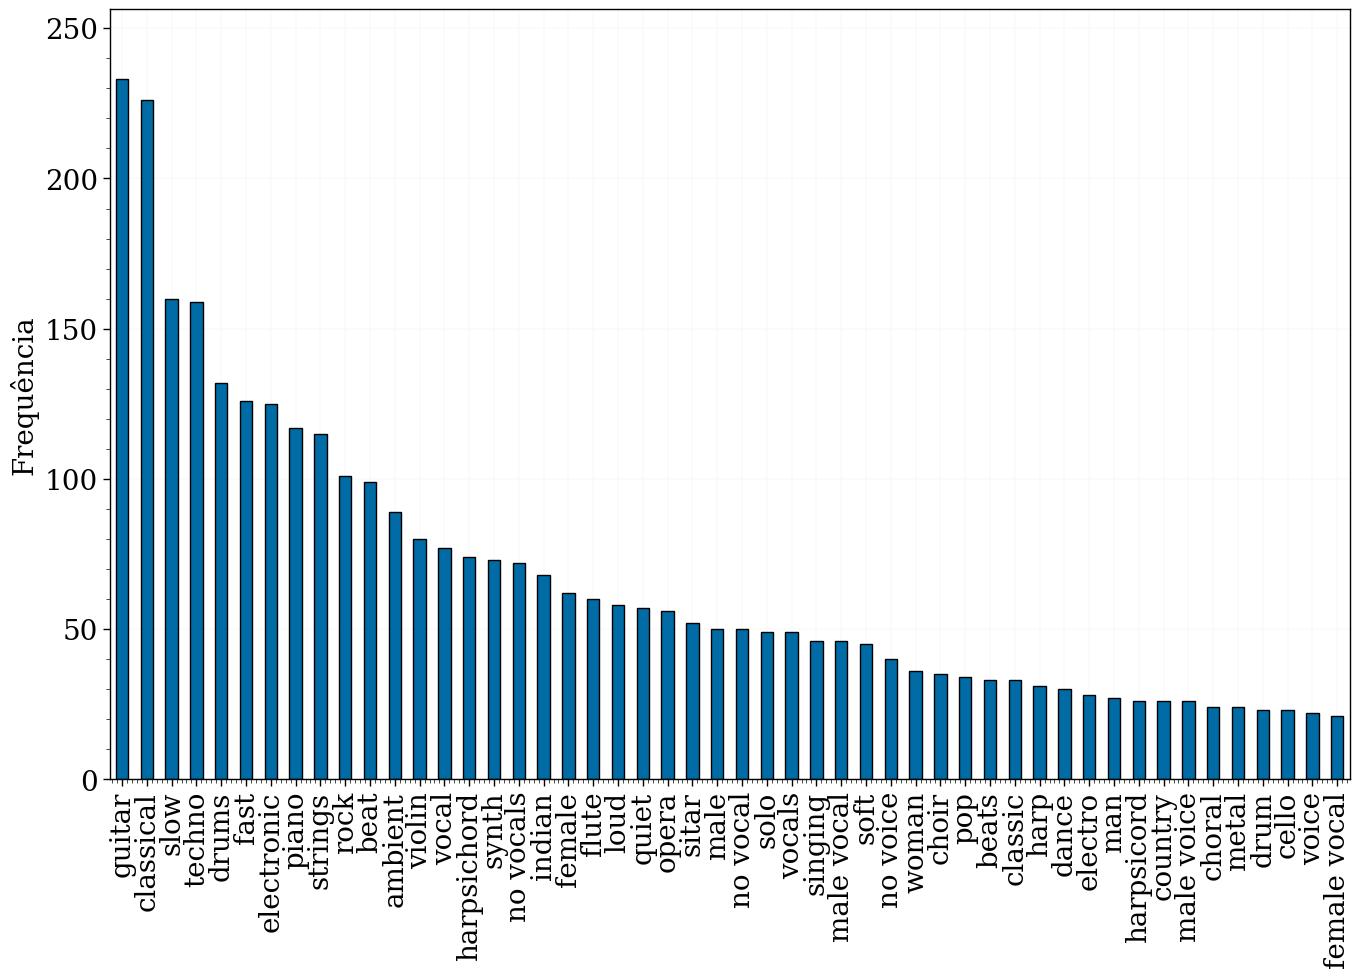

In [107]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [108]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'male', 'no vocal', 'solo', 'vocals',
       'singing', 'male vocal', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'harpsicord',
       'country', 'male voice', 'choral', 'metal', 'drum', 'cello', 'voice',
       'female vocal'],
      dtype='object')

In [109]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

In [110]:
# (df.sum(axis=1) == 0).any()
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,...,harpsicord,country,male voice,choral,metal,drum,cello,voice,female vocal,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
29,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


In [111]:
# df = df[df.sum(axis=1) != 0]
df = df[df.drop(columns=['mp3_path']).sum(axis=1) != 0]
df = df.sample(frac=1)
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,...,harpsicord,country,male voice,choral,metal,drum,cello,voice,female vocal,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
48992,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1/william_brooks-karma_dogs-12-still_around-0-...
22747,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0/barbara_leoni-human_needs-05-human_needs-117...
2142,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,b/wicked_allstars-dark_clouds-01-jazz_house-0-...
5473,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/bjorn_fogelberg-karooshi_porn-01-trioxidatio...
44938,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1/tanya_tomkins_and_eric_zivian-beethoven_pian...


In [112]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [113]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [114]:
def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [115]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = jnp.array(data_train)
Y_train = jnp.array(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = jnp.array(data_val)
Y_val = jnp.array(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = jnp.array(data_test)
Y_test = jnp.array(test_df.drop('mp3_path', axis=1).values)

## Iterating in Batches

In [116]:
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1],
                             X_train.shape[2]))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [117]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape
Yb.shape

(16, 50)

In [118]:
Yb.shape

(16, 50)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [119]:
class Baseline(nn.Module):
    @nn.compact
    def __call__(self, x):

        for _ in range(3):
            x = nn.Conv(96, kernel_size=(3, ), strides=(1, ))(x)

            x = nn.relu(x)
            x = nn.max_pool(x, window_shape=(3, ), strides=(1, ))

        x = nn.avg_pool(x, window_shape=(1, ))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(50)(x)
        x = nn.log_softmax(x)
        return x

In [120]:
model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

In [121]:
logits = Baseline().apply(variables, Xb)
logits.shape

(16, 50)

In [122]:
@jax.jit
def cross_entropy_loss(logits, Yb):
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [123]:
logits = Baseline().apply(variables, Xb)
cross_entropy_loss(logits, Yb)

Array(42.99848, dtype=float32)

In [124]:
logits = Baseline().apply(variables, X_train)
cross_entropy_loss(logits, Y_train)

Array(64.11048, dtype=float32)

In [125]:
logits = Baseline().apply(variables, X_val)
cross_entropy_loss(logits, Y_val)

Array(65.5717, dtype=float32)

In [126]:
logits = Baseline().apply(variables, X_test)
cross_entropy_loss(logits, Y_test)

Array(60.839653, dtype=float32)

In [127]:
@jax.jit
def train_step(Xb, Yb, state):
    def loss_fn(params):
        logits = Baseline().apply({'params': params}, Xb)
        loss = cross_entropy_loss(logits, Yb)
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [134]:
from flax.training import train_state

model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

lr = 0.0005
iter = 50

params = variables['params']
tx = optax.sgd(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                     X_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                   X_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 11.669482231140137; Val Loss = 11.832786560058594
Iter: 10; Train Loss 9.411405563354492; Val Loss = 11.655441284179688
Iter: 20; Train Loss 10.462678909301758; Val Loss = 15.156314849853516
Iter: 30; Train Loss 6.431402206420898; Val Loss = 13.378546714782715
Iter: 40; Train Loss 6.059873580932617; Val Loss = 14.553665161132812


In [149]:

def auto_tagging(id, df, X, model, params, topk):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))
    X = jnp.array([X[id]])
    logit = model().apply({'params': params}, X)[0]
    idx = logit.argsort()[-topk:][::-1]
    column_names = row.index[idx]
    topk_tags = row[column_names]



    return wave, topk_tags

In [150]:
import IPython.display as ipd
def mean_average_precision(relevance_list):

    relevant_count = 0
    precision_sum = 0.0

    for i, rel in enumerate(relevance_list,start=1):

        if rel == 1:
            relevant_count += 1
            precision_sum += relevant_count / i  #
    return precision_sum / len(relevance_list) if  len(relevance_list) > 0 else 0.0



maps=[]
accs=[]
for j in range(test_df.shape[0]):
  wv, lizt = auto_tagging(j, test_df, X_test, Baseline, state.params, 5)

  maps.append(mean_average_precision(lizt.values))
  accs.append(len([k for k in lizt if k==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in test set " + str(np.average(maps)))
print("average of Precsision @ 5 in test set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(val_df.shape[0]):
  wv, lizt = auto_tagging(j, val_df, X_test, Baseline, state.params, 5)

  maps.append(mean_average_precision(lizt.values))
  accs.append(len([k for k in lizt if k==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in val set " + str(np.average(maps)))
print("average of Precsision @ 5 in val set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(train_df.shape[0]):
  wv, lizt = auto_tagging(j, train_df, X_test, Baseline, state.params, 5)

  maps.append(mean_average_precision(lizt.values))
  accs.append(len([k for k in lizt if k==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in train set " + str(np.average(maps)))
print("average of Precsision @ 5 in train set " + str(np.average(accs)))



average of Mean Average Precsision in test set 0.15859375000000003
average of Precsision @ 5 in test set 0.2296875
average of Mean Average Precsision in val set 0.049140625
average of Precsision @ 5 in val set 0.08750000000000001
average of Mean Average Precsision in train set 0.06380208333333333
average of Precsision @ 5 in train set 0.11744791666666667


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings!

In [151]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class MusicGenreDataset(Dataset):
    def __init__(self, df, sample_rate=16000, n_mels=96):
        self.data = df
        self.labels = self.data.columns[1:-1]
        self.sample_rate = sample_rate
        self.mel_transform = transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=2048,
            hop_length=512,
            n_mels=n_mels
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        npy_path = "/content/waveform/"+row["mp3_path"]
        waveform = np.load(npy_path)
        waveform = torch.tensor(waveform, dtype=torch.float32)

        if len(waveform.shape) == 1:
            waveform = waveform.unsqueeze(0)
        mel_spec = self.mel_transform(waveform)
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()
        labels = torch.tensor(row[self.labels].values.astype(float), dtype=torch.float32)

        return mel_spec, labels


In [161]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 5))

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


In [162]:
import torch.optim as optim

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for mel_spec, labels in train_loader:

            if   torch.isnan(mel_spec).any():
               pass
            else:
              mel_spec, labels = mel_spec.to(device), labels.to(device)


              outputs = model(mel_spec)
              loss = criterion(outputs, labels)


              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


In [163]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]


In [164]:
from torch.utils.data import DataLoader

csv_path = "/content/subset_magnatune.csv"


train_dataset = MusicGenreDataset(train_df)
val_dataset = MusicGenreDataset(val_df)
test_dataset = MusicGenreDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)


num_classes = len(train_dataset.labels)

model = AudioCNN(num_classes=num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model, train_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20], Loss: 0.2691
Epoch [2/20], Loss: 0.2119
Epoch [3/20], Loss: 0.2065
Epoch [4/20], Loss: 0.1985
Epoch [5/20], Loss: 0.1928
Epoch [6/20], Loss: 0.1889
Epoch [7/20], Loss: 0.1858
Epoch [8/20], Loss: 0.1810
Epoch [9/20], Loss: 0.1781
Epoch [10/20], Loss: 0.1731
Epoch [11/20], Loss: 0.1679
Epoch [12/20], Loss: 0.1652
Epoch [13/20], Loss: 0.1582
Epoch [14/20], Loss: 0.1517
Epoch [15/20], Loss: 0.1466
Epoch [16/20], Loss: 0.1393
Epoch [17/20], Loss: 0.1349
Epoch [18/20], Loss: 0.1232
Epoch [19/20], Loss: 0.1158
Epoch [20/20], Loss: 0.1096


In [165]:

import torch
import torch.nn as nn

model.eval()


AudioCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(2, 5), stride=(2, 5), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=49, bias=True)
)

In [166]:
import torch
import pandas as pd
import numpy as np

def predict_from_clip_id(clip_id, csv_path, model, top_k=50):

    df = pd.read_csv(csv_path)
    row = df.iloc[clip_id].copy()
    npy_path = "/content/waveform/"+row["mp3_path"]
    waveform = np.load(npy_path)
    waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
    mel_transform = transforms.MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=96)
    mel_spec = mel_transform(waveform)
    mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()
    mel_spec = mel_spec.unsqueeze(0)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    mel_spec = mel_spec.to(device)



    with torch.no_grad():
        logits = model(mel_spec)

        probabilities = torch.sigmoid(logits)


    top_probs, top_indices = torch.topk(probabilities, 5)
    top_classes = [df.columns[1:-1][i] for i in top_indices[0].tolist()]
    labs =[df.loc[clip_id,i] for i in top_classes]

    return waveform, list(zip(top_classes,labs, top_probs[0].tolist()))


maps=[]
accs=[]
for j in range(896,896+128):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in test set " + str(np.average(maps)))
print("average of Precsision @ 5  in test set " + str(np.average(accs)))




average of Mean Average Precsision in test set 0.011302083333333334
average of Precsision @ 5  in test set 0.0265625


In [167]:
maps=[]
accs=[]
for j in range(768,896):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in val set " + str(np.average(maps)))
print("average of Precsision @ 5  in val set " + str(np.average(accs)))

average of Mean Average Precsision in val set 0.005078125
average of Precsision @ 5  in val set 0.0171875


In [168]:


maps=[]
accs=[]
for j in range(0,768):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in train set " + str(np.average(maps)))
print("average of Precsision @ 5  in train set " + str(np.average(accs)))

average of Mean Average Precsision in train set 0.007530381944444445
average of Precsision @ 5  in train set 0.01875


### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...).

* You can also use ResNet or other CNNs with skip connections.

* Furthermore, you can augment data using digital audio effects.

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN_v2(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioCNN_v2, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 5))

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


In [170]:
def train_v2(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for mel_spec, labels in train_loader:
            # Handle NaN values
            mel_spec[torch.isnan(mel_spec)] = 0

            mel_spec, labels = mel_spec.to(device), labels.to(device)

            optimizer.zero_grad()  # Moved zero_grad to before forward pass
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


In [171]:
from torch.utils.data import DataLoader

csv_path = "/content/subset_magnatune.csv"


train_dataset = MusicGenreDataset(train_df)
val_dataset = MusicGenreDataset(val_df)
test_dataset = MusicGenreDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


num_classes = len(train_dataset.labels)

model = AudioCNN_v2(num_classes=num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_v2(model, train_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20], Loss: 0.3853
Epoch [2/20], Loss: 0.2175
Epoch [3/20], Loss: 0.2035
Epoch [4/20], Loss: 0.1973
Epoch [5/20], Loss: 0.1912
Epoch [6/20], Loss: 0.1866
Epoch [7/20], Loss: 0.1824
Epoch [8/20], Loss: 0.1766
Epoch [9/20], Loss: 0.1718
Epoch [10/20], Loss: 0.1672
Epoch [11/20], Loss: 0.1621
Epoch [12/20], Loss: 0.1560
Epoch [13/20], Loss: 0.1503
Epoch [14/20], Loss: 0.1435
Epoch [15/20], Loss: 0.1365
Epoch [16/20], Loss: 0.1300
Epoch [17/20], Loss: 0.1256
Epoch [18/20], Loss: 0.1219
Epoch [19/20], Loss: 0.1119
Epoch [20/20], Loss: 0.1037


In [172]:
model.eval()
maps=[]
accs=[]
for j in range(896,896+128):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in test set " + str(np.average(maps)))
print("average of Precsision @5 in test set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(768,896):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in val set " + str(np.average(maps)))
print("average of Precsision @5  in val set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(0,768):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in train set " + str(np.average(maps)))
print("average of Precsision @5  in train set " + str(np.average(accs)))

average of Mean Average Precsision in test set 0.014348958333333333
average of Precsision @5 in test set 0.0375
average of Mean Average Precsision in val set 0.007291666666666667
average of Precsision @5  in val set 0.015625
average of Mean Average Precsision in train set 0.007712673611111111
average of Precsision @5  in train set 0.018229166666666668


### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751

In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class AudioCNN_Pro(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioCNN_Pro, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3))

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = self.adaptive_pool(x)
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_v3(model, train_loader, criterion, optimizer, device, num_epochs=10, accumulation_steps=4):
    model.to(device)
    model.train()

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for i, (mel_spec, labels) in enumerate(train_loader):
            if torch.isnan(mel_spec).any():
                continue

            mel_spec, labels = mel_spec.to(device), labels.to(device)

            outputs = model(mel_spec)
            loss = criterion(outputs, labels) / accumulation_steps

            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


In [174]:

from torch.utils.data import DataLoader

csv_path = "/content/subset_magnatune.csv"


train_dataset = MusicGenreDataset(train_df)
val_dataset = MusicGenreDataset(val_df)
test_dataset = MusicGenreDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


num_classes = len(train_dataset.labels)

model = AudioCNN_Pro(num_classes=num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_v3(model, train_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20], Loss: 0.5710
Epoch [2/20], Loss: 0.3691
Epoch [3/20], Loss: 0.2366
Epoch [4/20], Loss: 0.2172
Epoch [5/20], Loss: 0.2155
Epoch [6/20], Loss: 0.2072
Epoch [7/20], Loss: 0.2024
Epoch [8/20], Loss: 0.1962
Epoch [9/20], Loss: 0.1947
Epoch [10/20], Loss: 0.1930
Epoch [11/20], Loss: 0.1898
Epoch [12/20], Loss: 0.1855
Epoch [13/20], Loss: 0.1835
Epoch [14/20], Loss: 0.1821
Epoch [15/20], Loss: 0.1800
Epoch [16/20], Loss: 0.1802
Epoch [17/20], Loss: 0.1781
Epoch [18/20], Loss: 0.1753
Epoch [19/20], Loss: 0.1762
Epoch [20/20], Loss: 0.1761


In [175]:
model.eval()
maps=[]
accs=[]
for j in range(896,896+128):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)

# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in test set " + str(np.average(maps)))
print("average of Precsision @ 5 in test set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(768,896):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in val set " + str(np.average(maps)))
print("average of Precsision @ 5 in val set " + str(np.average(accs)))

maps=[]
accs=[]
for j in range(0,768):
  wv, lizt = predict_from_clip_id(j,"/content/subset_magnatune.csv",model)
  for i in lizt:
    maps.append(mean_average_precision([k[1] for k in lizt]))
    accs.append(len([k[1] for k in lizt if k[1]==1 ])/5)
# ipd.Audio(wv, rate=16000)
print("average of Mean Average Precsision in train set " + str(np.average(maps)))
print("average of Precsision @ 5 in train set " + str(np.average(accs)))

average of Mean Average Precsision in test set 0.012630208333333334
average of Precsision @ 5 in test set 0.0328125
average of Mean Average Precsision in val set 0.008229166666666666
average of Precsision @ 5 in val set 0.0203125
average of Mean Average Precsision in train set 0.00787326388888889
average of Precsision @ 5 in train set 0.01953125
